In [101]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [102]:
def selecionar_df(mes, margens=None):
    df = pd.read_csv(f'../dados-tratados/pc-{mes:0>2}.csv', sep=';')

    colunas = [
        'Cargo',
        'Teste_coronavírus', 
        'Exame SWAB', 'Resultado_SWAB', 
        'Exame_sangue_dedo', 'Resultado_sangue_dedo',
        'Exame_sangue_braco', 'Resultado_sangue_braco'
    ]

    df_selecionado = df[colunas]

    df_selecionado = df_selecionado[df['Teste_coronavírus'] == 'Sim']

    df_selecionado["Covid"] = df_selecionado[["Resultado_SWAB", "Resultado_sangue_dedo", "Resultado_sangue_braco"]].apply(
        lambda row: "Positivo" if "Positivo" in row.values else "Negativo", axis=1
    )

    df_selecionado["Cargo"] = df_selecionado["Cargo"].fillna("Não trabalha")
    
    cargo_counts = df_selecionado["Cargo"].value_counts()
    
    if margens is not None:
        cargos_frequentes = list(cargo_counts.nlargest(margens).index)
        cargos_menos_frequentes = list(cargo_counts.nsmallest(margens).index)
        df_selecionado = df_selecionado[df_selecionado['Cargo'].isin(cargos_frequentes) | df_selecionado['Cargo'].isin(cargos_menos_frequentes)]

    df_selecionado.drop(columns=['Teste_coronavírus', 
        'Exame SWAB', 'Resultado_SWAB', 
        'Exame_sangue_dedo', 'Resultado_sangue_dedo',
        'Exame_sangue_braco', 'Resultado_sangue_braco'], inplace=True)

    return df_selecionado

In [108]:
def num_to_mes(mes):
    meses = {
        1: 'Janeiro',
        2: 'Fevereiro',
        3: 'Março',
        4: 'Abril',
        5: 'Maio',
        6: 'Junho',
        7: 'Julho',
        8: 'Agosto',
        9: 'Setembro',
        10: 'Outubro',
        11: 'Novembro',
        12: 'Dezembro'
    }
    return meses[mes]


In [ ]:
def gerar_grafo_mes(mes, margens=None, mostrar_rotulo=False):
    df = selecionar_df(mes, margens)

    # Criando o grafo
    G = nx.Graph()

    # Contagem dos casos por cargo
    total_por_cargo = df["Cargo"].value_counts()
    casos_por_cargo = df.groupby(["Cargo", "Covid"]).size().unstack(fill_value=0)

    # Adicionando nós
    cargos = df["Cargo"].unique()
    covid_status = ["Negativo", "Positivo"]

    G.add_nodes_from(cargos, bipartite=0)  # Grupo 0 (cargos)
    G.add_nodes_from(covid_status, bipartite=1)  # Grupo 1 (positivo/negativo)

    # Adicionando arestas
    for cargo in cargos:
        if cargo in casos_por_cargo.index:
            for status in covid_status:
                if status in casos_por_cargo.columns:
                    count = casos_por_cargo.loc[cargo, status]
                    if count > 0:
                        G.add_edge(cargo, status)

    # Definindo posições dos nós
    pos = {}

    # Definir posição fixa para "Negativo" e "Positivo"
    pos["Negativo"] = (-1, 0)  # Esquerda
    pos["Positivo"] = (1, 0)  # Direita

    # Calcular posição dos cargos com base na proporção de casos
    for i, cargo in enumerate(cargos):
        if cargo in casos_por_cargo.index:
            total = total_por_cargo[cargo]
            pos_count = casos_por_cargo.loc[cargo, "Positivo"] if "Positivo" in casos_por_cargo.columns else 0
            neg_count = casos_por_cargo.loc[cargo, "Negativo"] if "Negativo" in casos_por_cargo.columns else 0

            if total > 0:
                x_pos = (pos_count * 3 - neg_count) / total  # Define deslocamento horizontal
            else:
                x_pos = 0

            pos[cargo] = (x_pos * 1.5, i * 0.5 - len(cargos) / 4)  # Distribuir verticalmente

    # Definição de cores e tamanhos
    node_colors = ["lightblue" if node in cargos else "lightcoral" if node == 'Positivo' else 'lightgreen' for node in G.nodes]
    node_sizes = [1000 if node in cargos else 2500 for node in G.nodes]  # Cargos menores, status maior

    # Desenhando o grafo
    plt.figure(figsize=(14, 8))
    nx.draw(
        G, pos, with_labels=True, node_color=node_colors, edge_color="gray",
        node_size=node_sizes, font_size=10, font_weight="bold",
        alpha=0.85, linewidths=1, edgecolors="black"
    )
    
    if mostrar_rotulo:
        edge_labels = {}
        for cargo in cargos:
            if cargo in casos_por_cargo.index:
                total = total_por_cargo[cargo]
                pos_count = casos_por_cargo.loc[cargo, "Positivo"] if "Positivo" in casos_por_cargo.columns else 0
                neg_count = casos_por_cargo.loc[cargo, "Negativo"] if "Negativo" in casos_por_cargo.columns else 0

                if total > 0:
                    pos_percent = (pos_count / total) * 100
                    neg_percent = (neg_count / total) * 100
                    label = f"Positivo: {pos_percent:.2f}%\nNegativo: {neg_percent:.2f}%"

                    # Adicionando rótulos nas arestas entre cargo e status
                    edge_labels[(cargo, "Positivo")] = f"{pos_percent:.2f}%"
                    edge_labels[(cargo, "Negativo")] = f"{neg_percent:.2f}%"

        # Exibindo rótulos nas arestas
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_weight="bold", font_color='black')

    plt.title(f"Grafo de Cargos x Resultado Covid de {num_to_mes(mes)} {f'(Apenas os {margens} mais frequentes e menos frequentes)' if margens is not None else ''}", fontsize=14)
    plt.show()


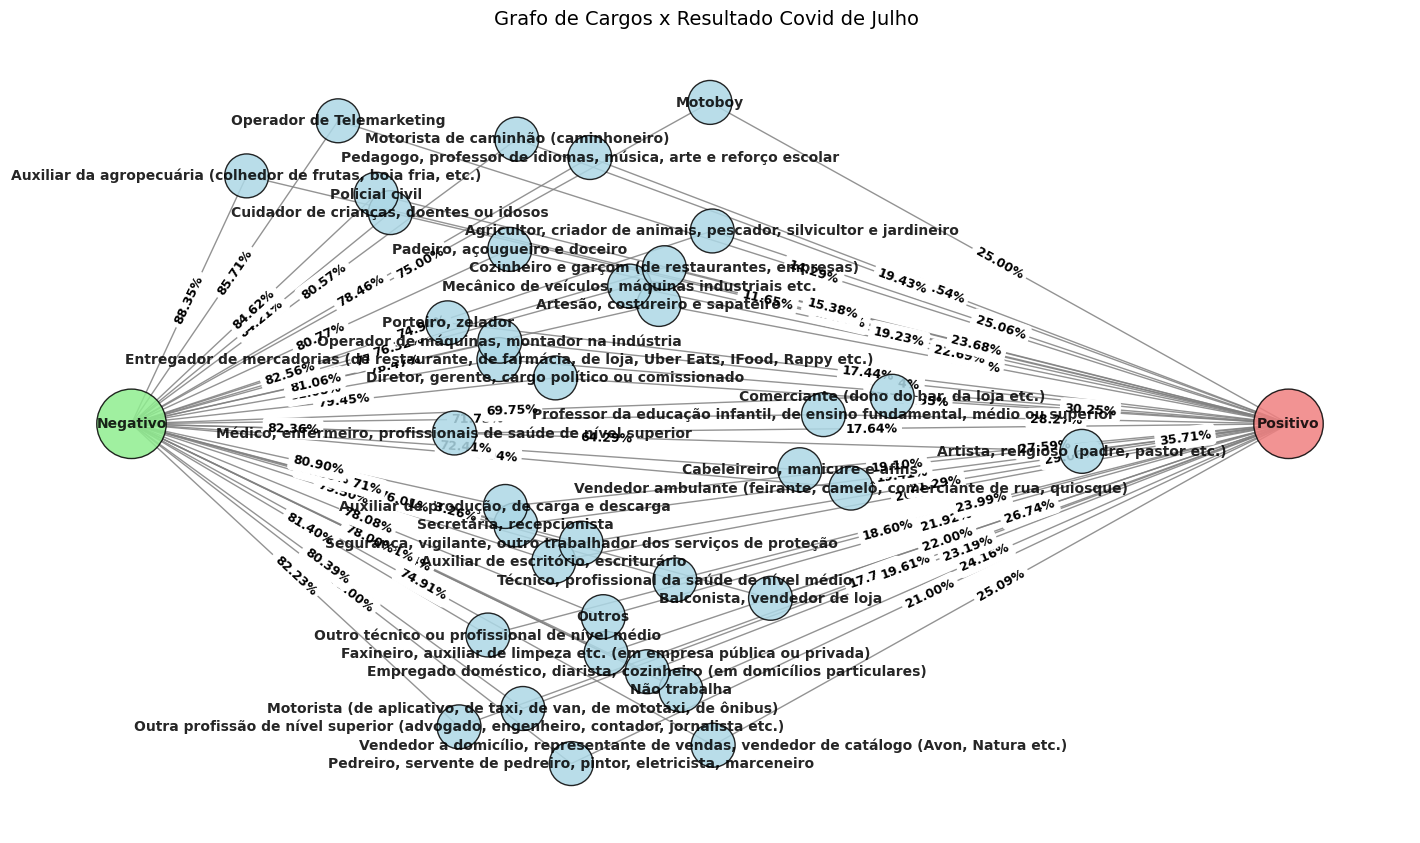

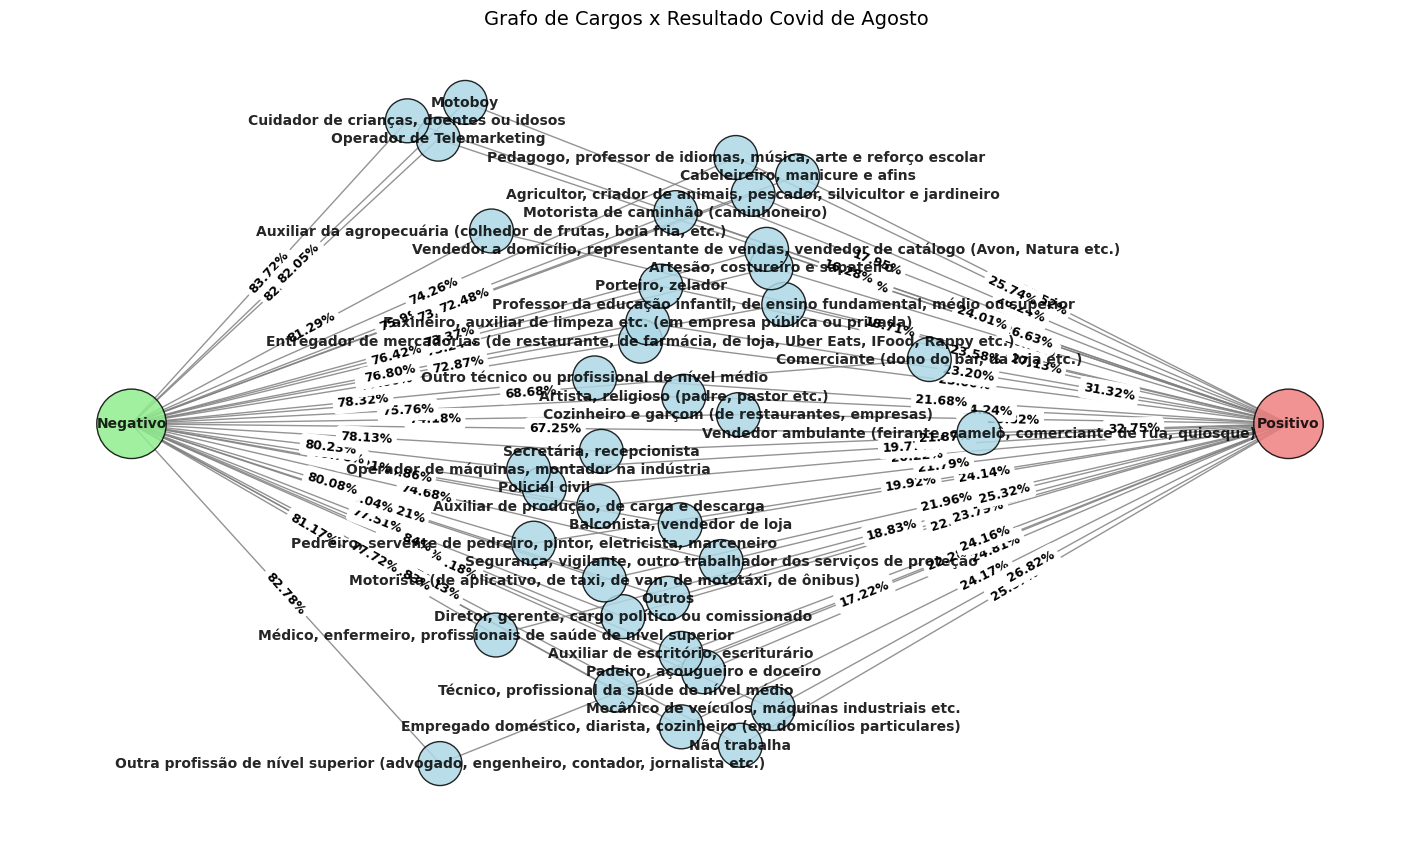

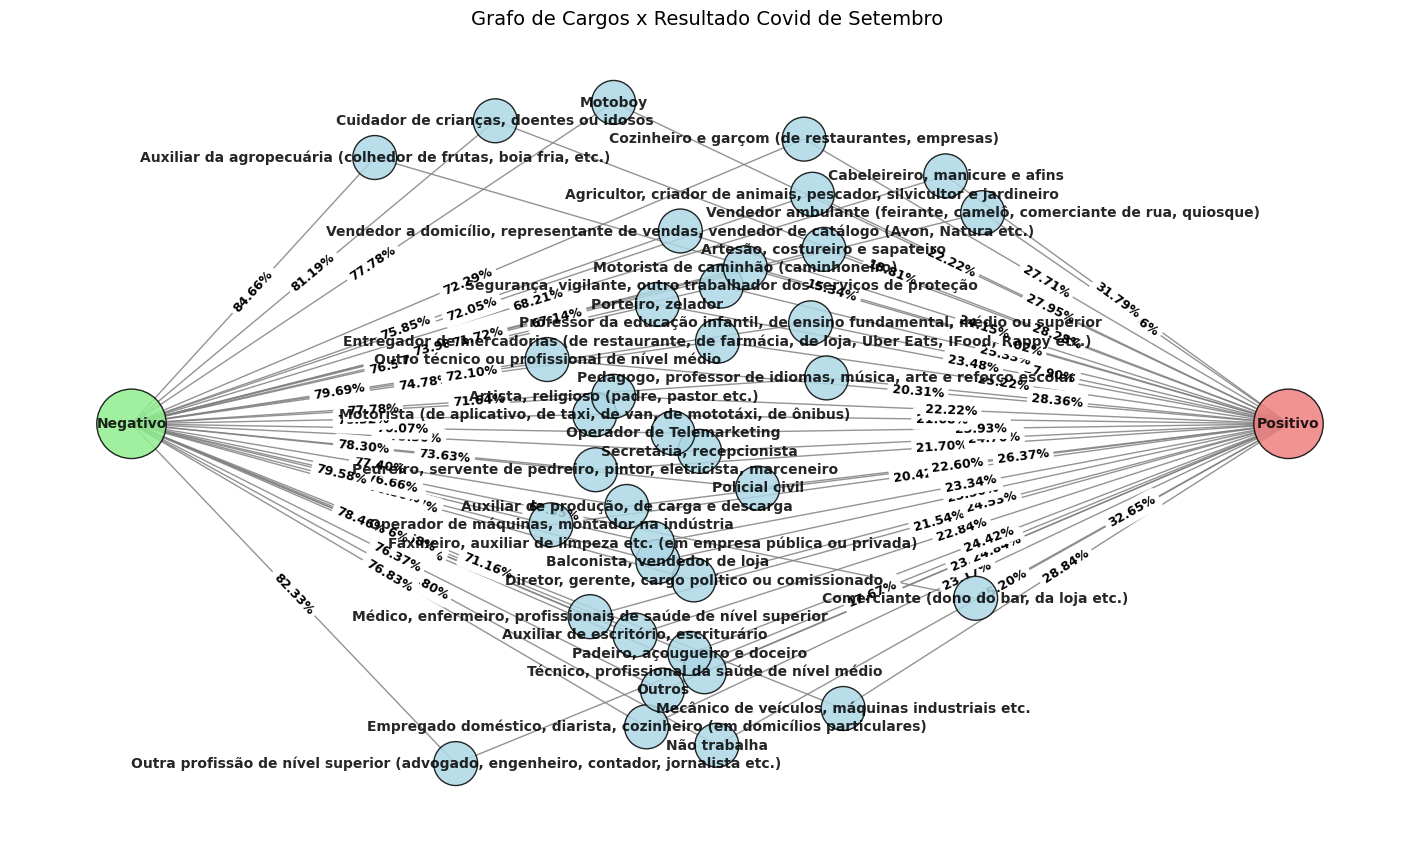

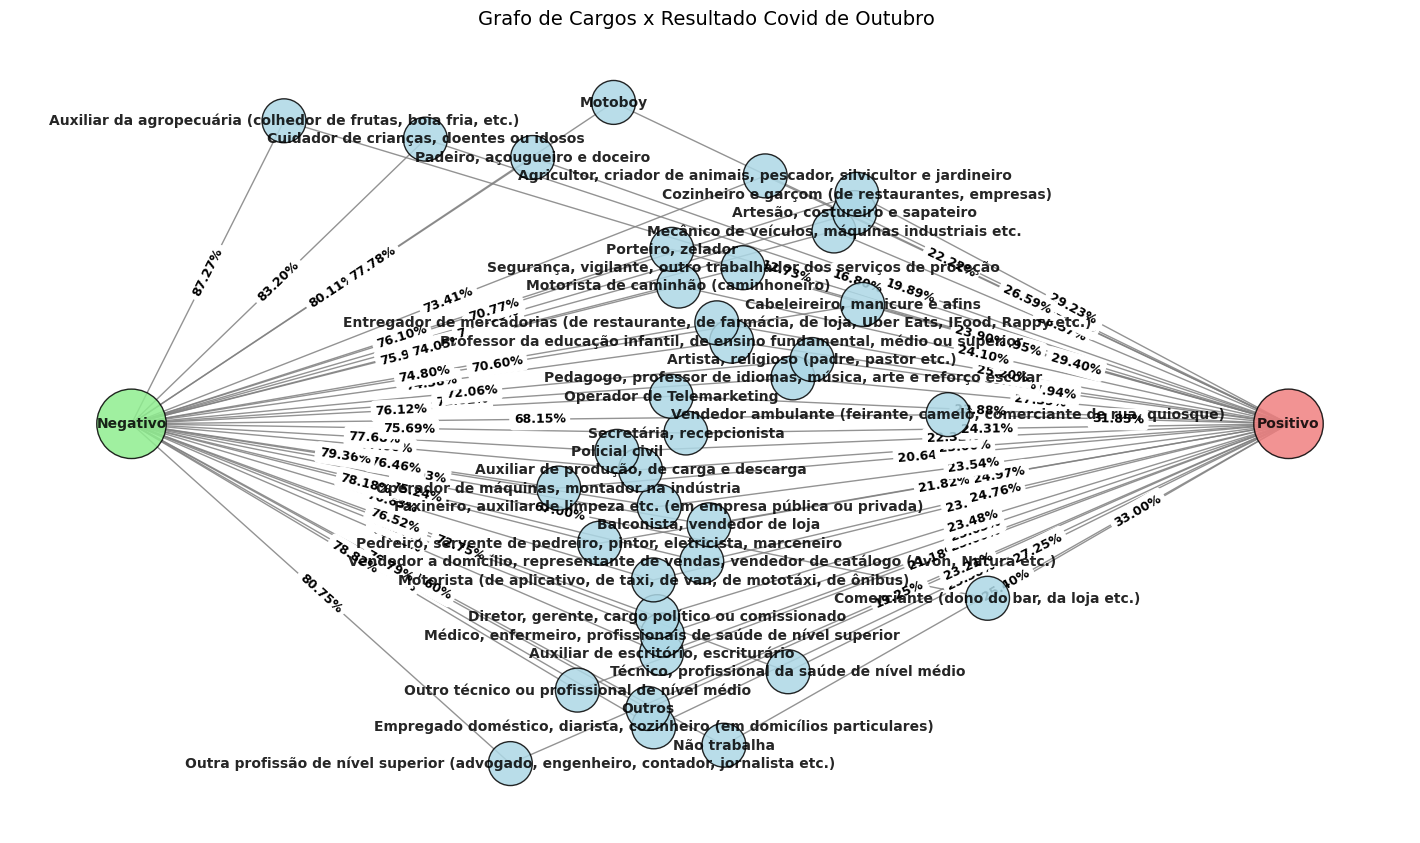

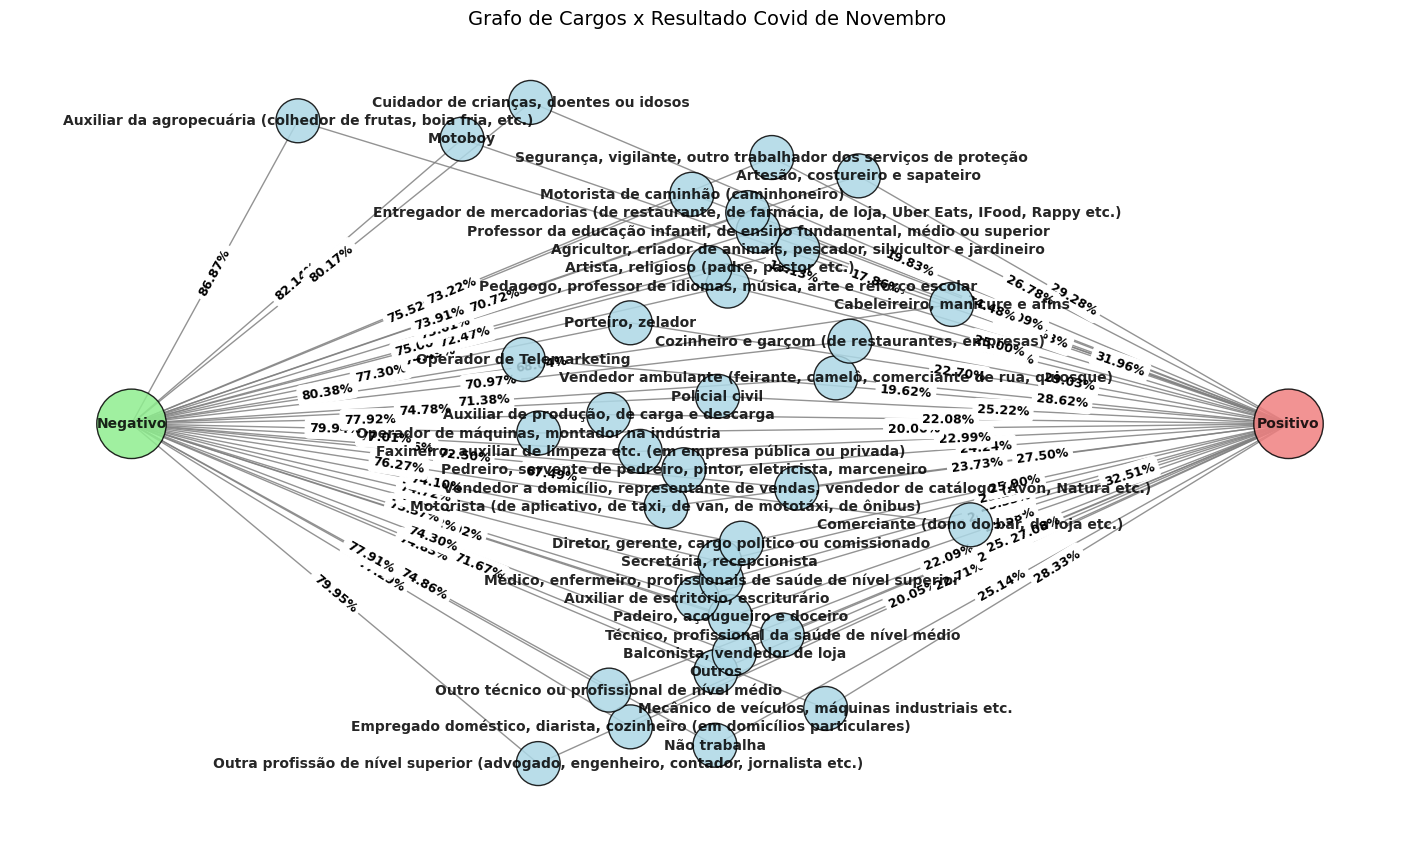

In [122]:
for i in range(7, 12):
    gerar_grafo_mes(i, mostrar_rotulo=True)

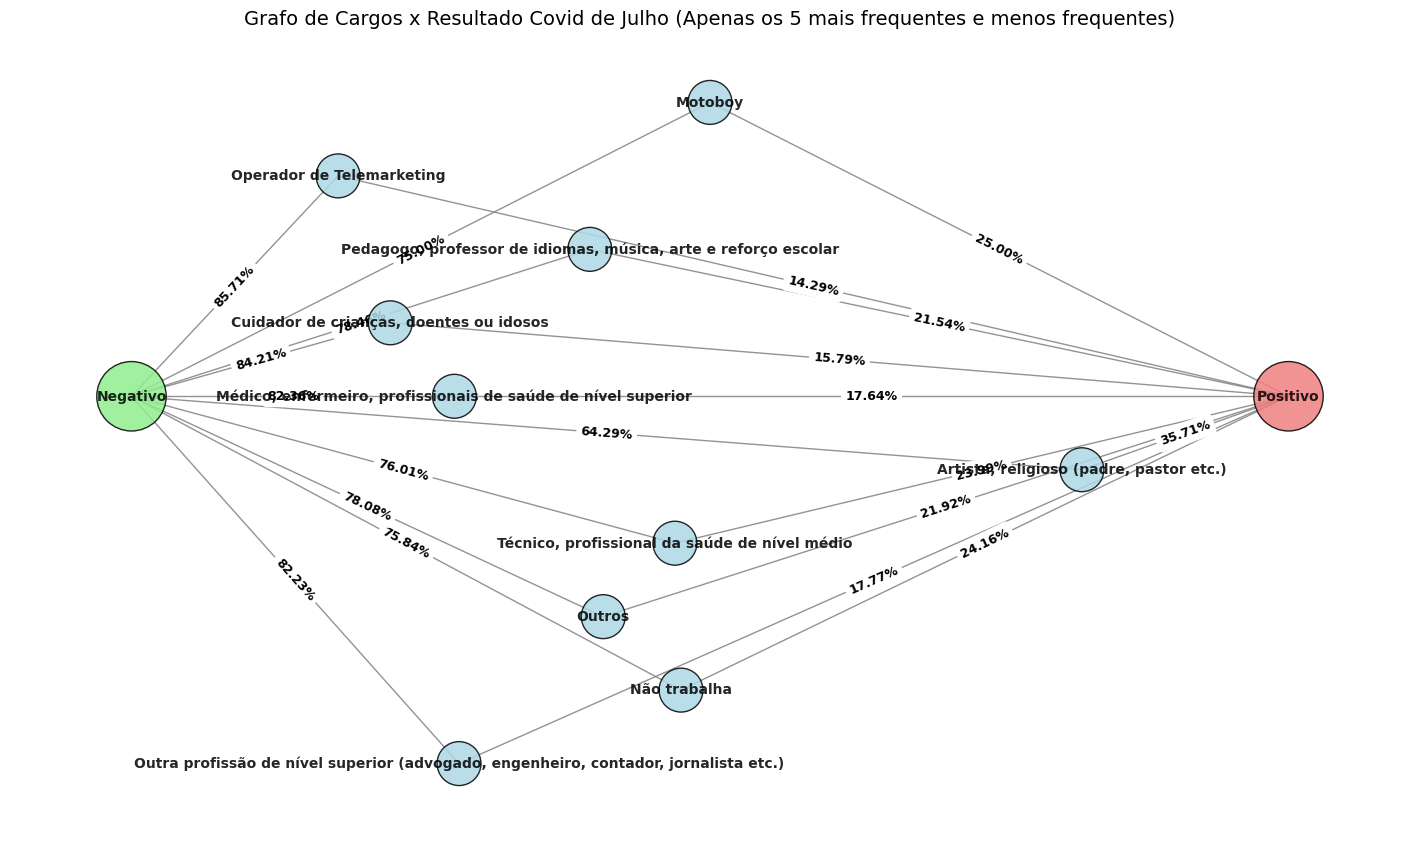

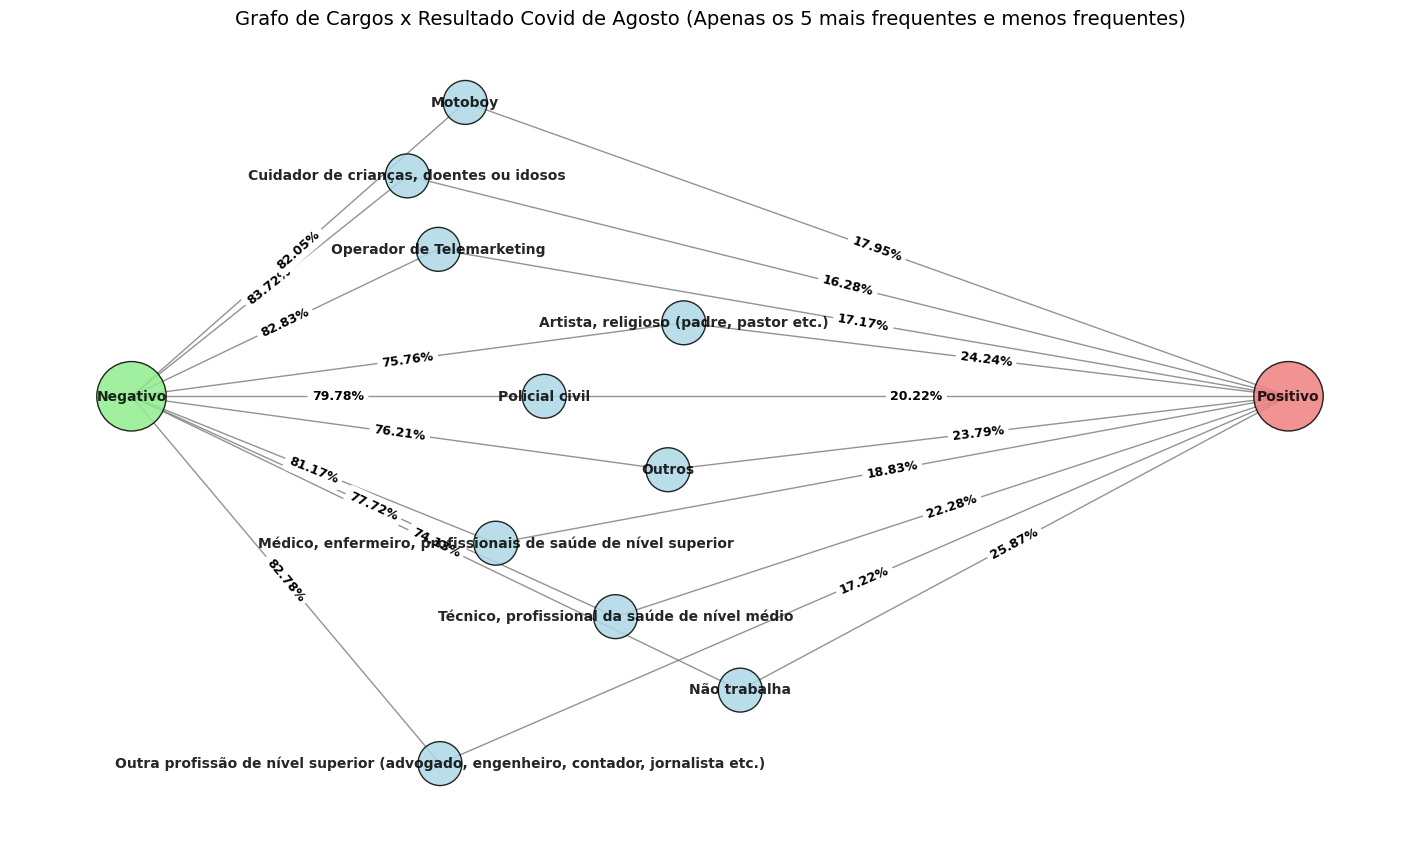

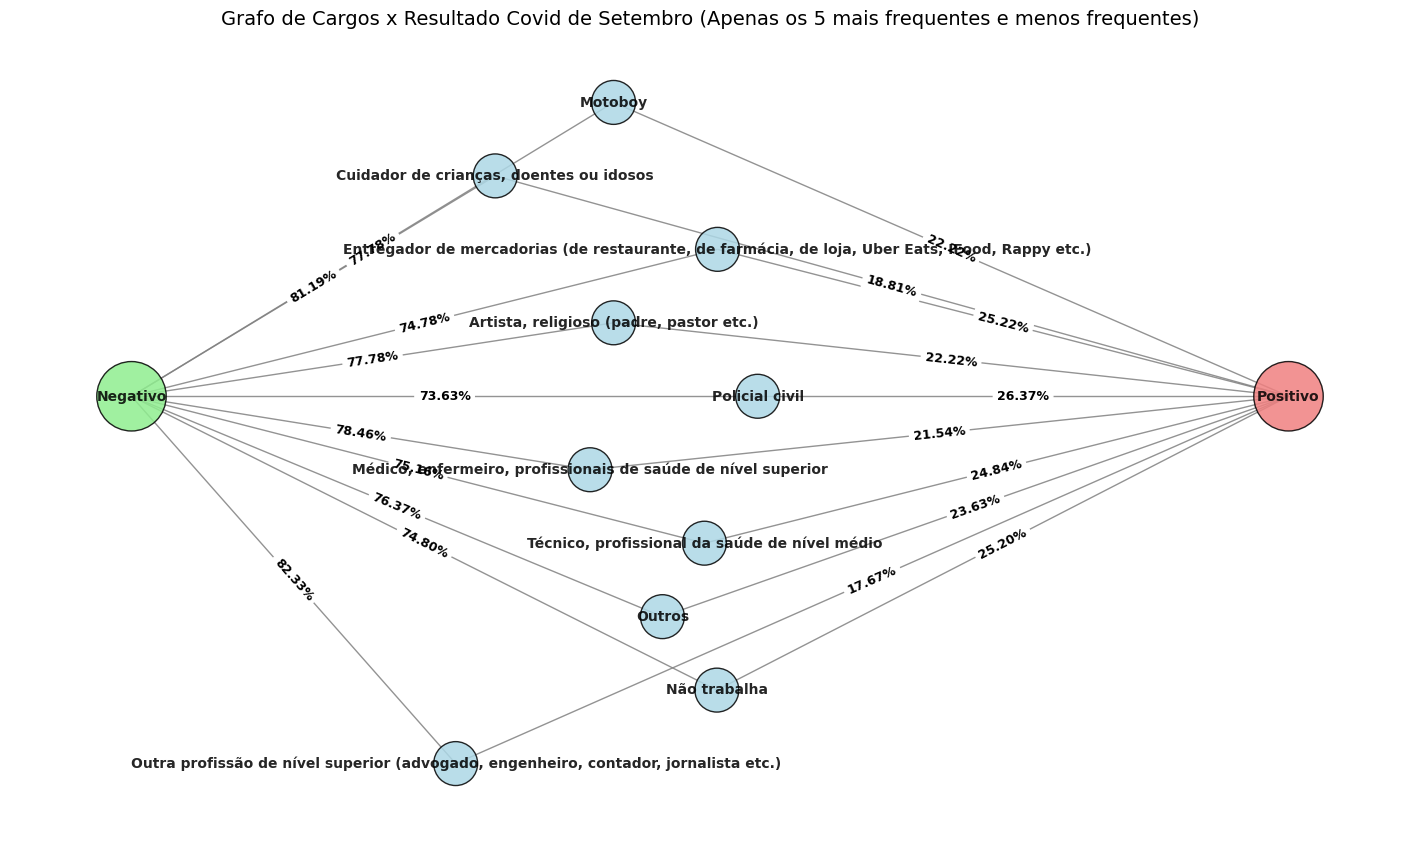

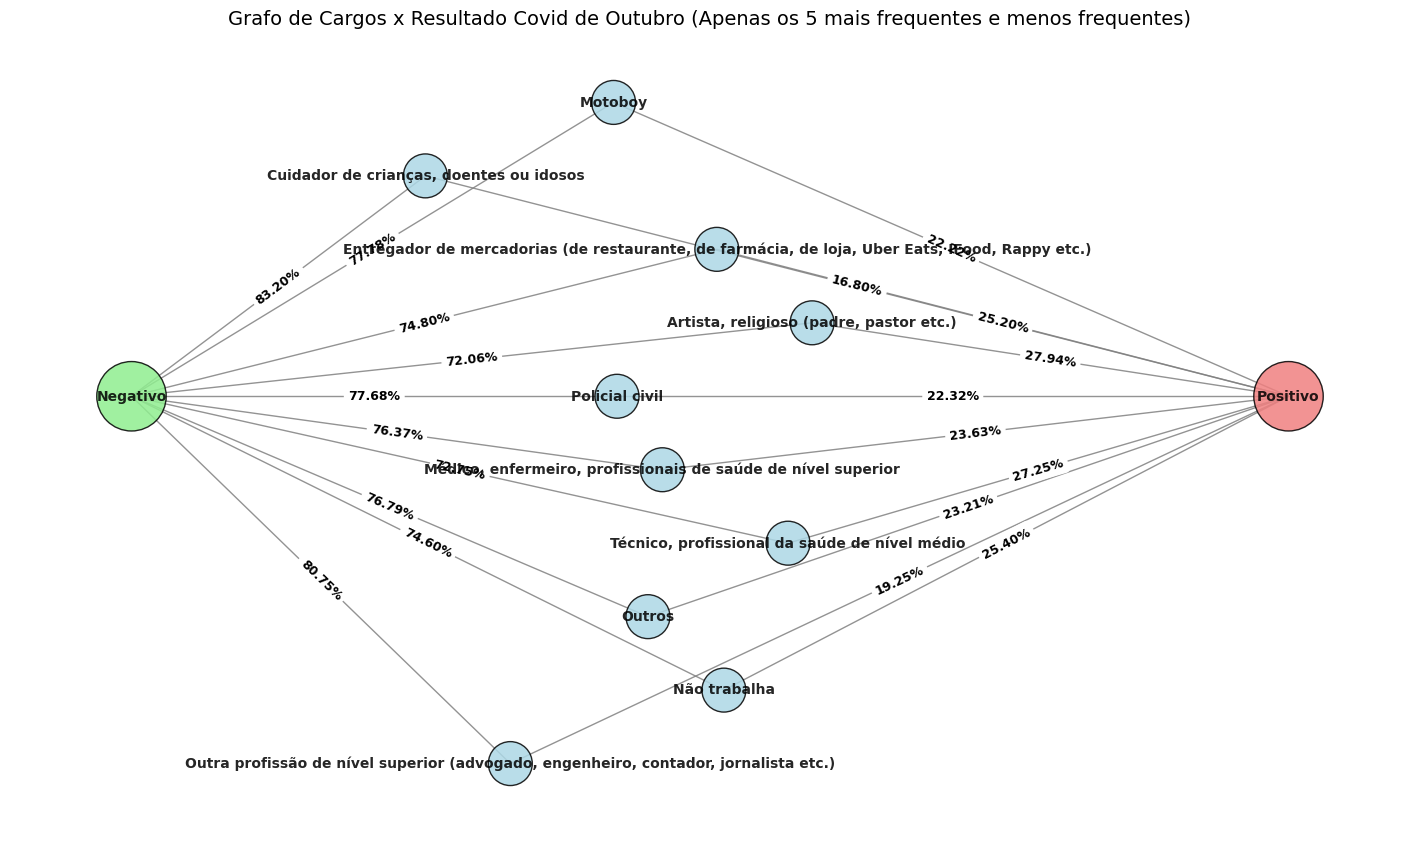

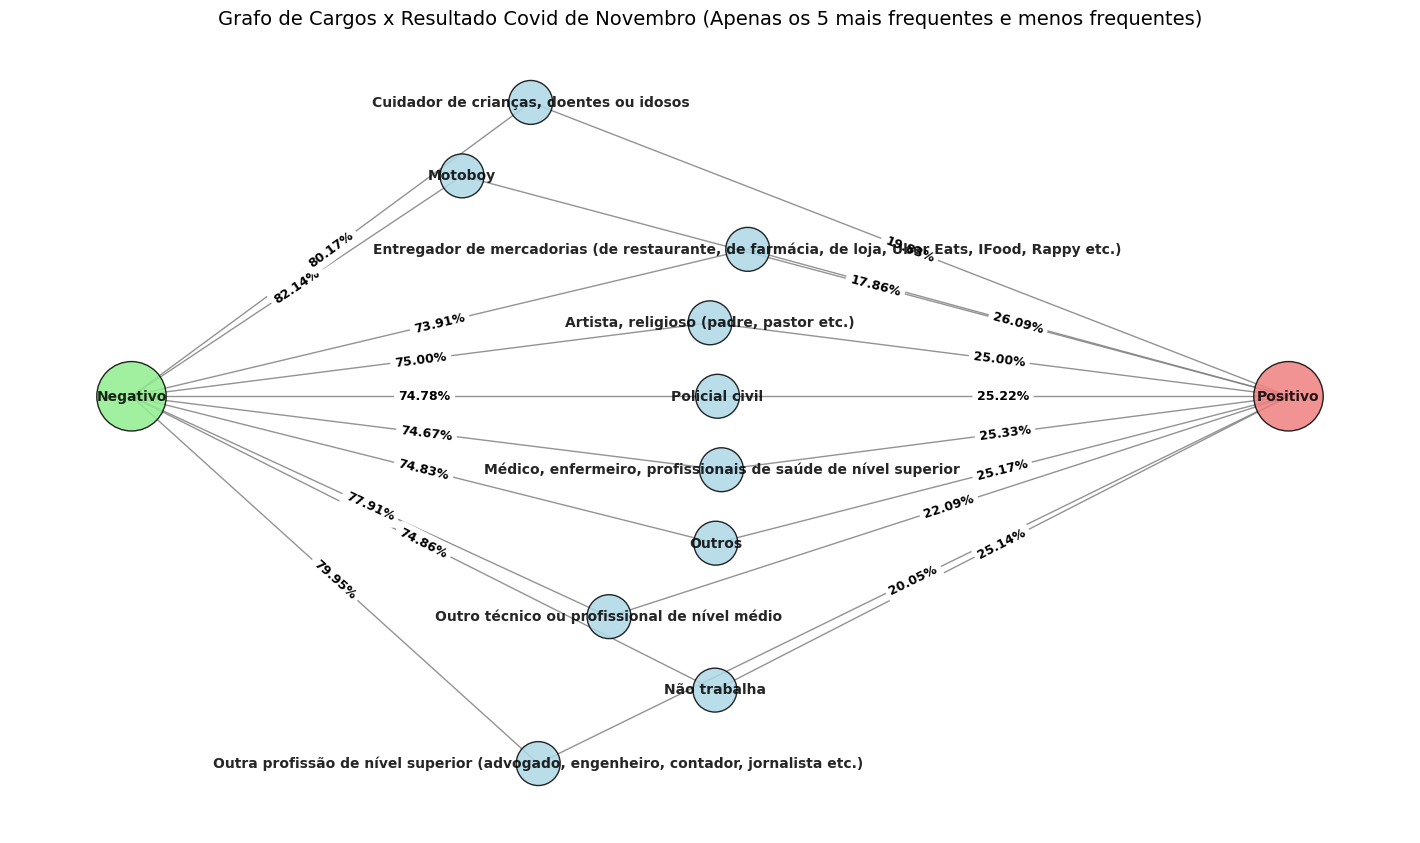

In [125]:
for i in range(7, 12):
    gerar_grafo_mes(i, 5, True)

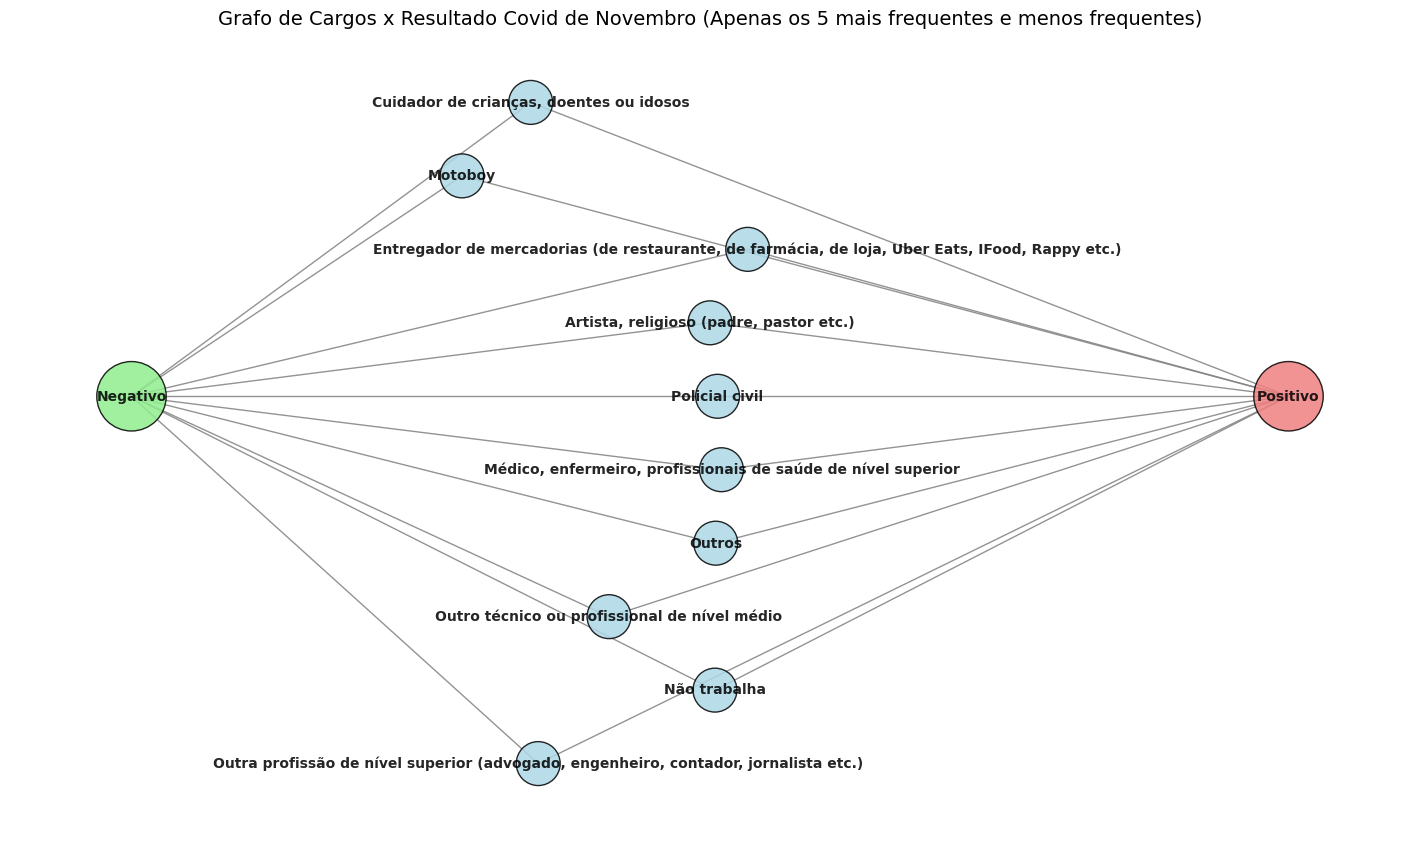

In [129]:
gerar_grafo_mes(11, 5)

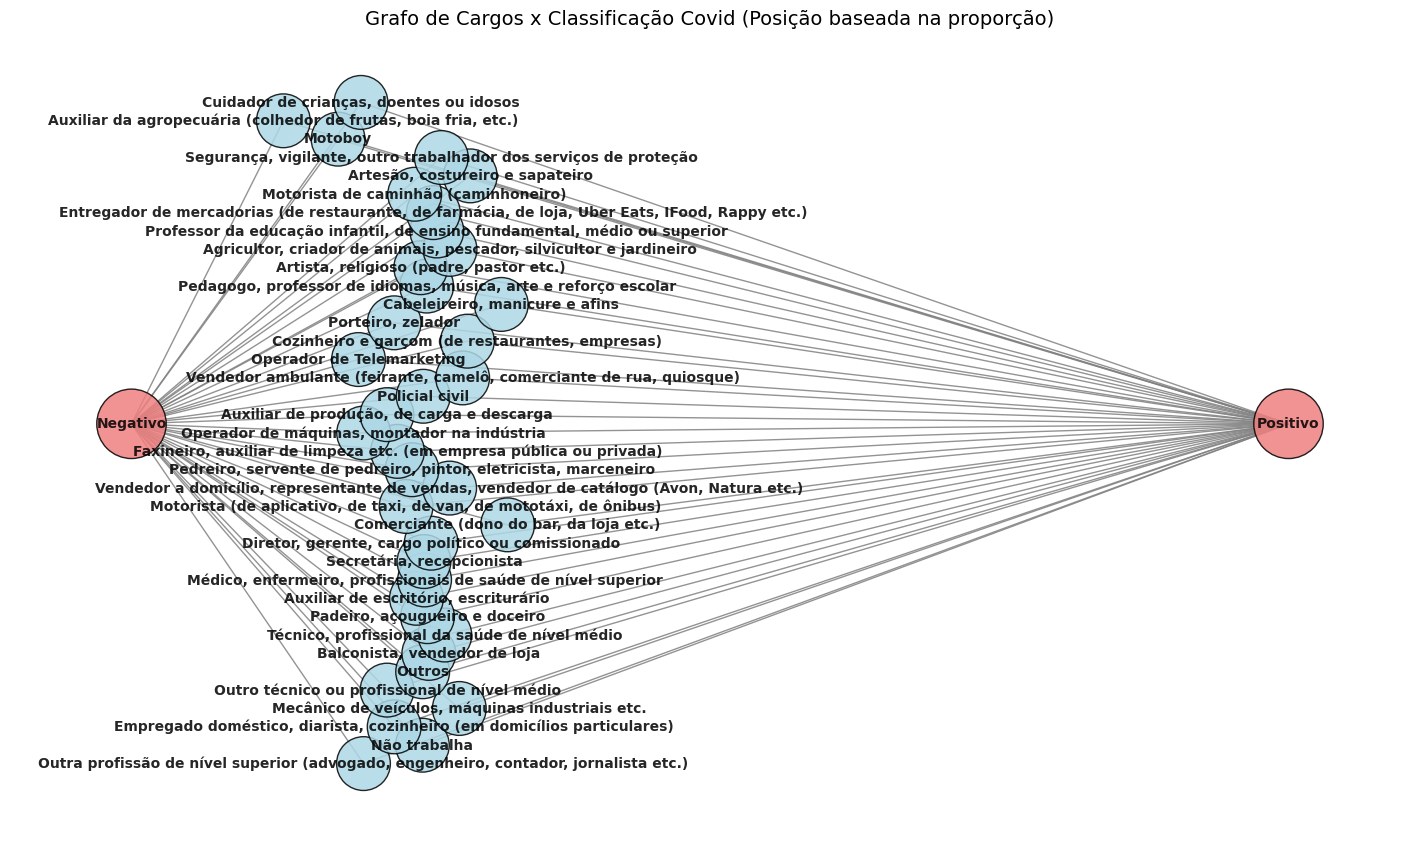

In [ ]:
df_selecionado = selecionar_df(11)

# Criando o grafo
G = nx.Graph()

# Contagem dos casos por cargo
total_por_cargo = df_selecionado["Cargo"].value_counts()
casos_por_cargo = df_selecionado.groupby(["Cargo", "Covid"]).size().unstack(fill_value=0)

# Adicionando nós
cargos = df_selecionado["Cargo"].unique()
covid_status = ["Negativo", "Positivo"]

G.add_nodes_from(cargos, bipartite=0)  # Grupo 0 (cargos)
G.add_nodes_from(covid_status, bipartite=1)  # Grupo 1 (positivo/negativo)

# Adicionando arestas
for cargo in cargos:
    if cargo in casos_por_cargo.index:
        for status in covid_status:
            if status in casos_por_cargo.columns:
                count = casos_por_cargo.loc[cargo, status]
                if count > 0:
                    G.add_edge(cargo, status)

# Definindo posições dos nós
pos = {}

# Definir posição fixa para "Negativo" e "Positivo"
pos["Negativo"] = (-1, 0)  # Esquerda
pos["Positivo"] = (1, 0)  # Direita

# Calcular posição dos cargos com base na proporção de casos
for i, cargo in enumerate(cargos):
    if cargo in casos_por_cargo.index:
        total = total_por_cargo[cargo]
        pos_count = casos_por_cargo.loc[cargo, "Positivo"] if "Positivo" in casos_por_cargo.columns else 0
        neg_count = casos_por_cargo.loc[cargo, "Negativo"] if "Negativo" in casos_por_cargo.columns else 0

        if total > 0:
            x_pos = (pos_count - neg_count) / total  # Define deslocamento horizontal
        else:
            x_pos = 0

        pos[cargo] = (x_pos, i * 0.5 - len(cargos) / 4)  # Distribuir verticalmente

# Definição de cores e tamanhos
node_colors = ["lightblue" if node in cargos else "lightcoral" for node in G.nodes]
node_sizes = [1500 if node in cargos else 2500 for node in G.nodes]  # Cargos menores, status maior

# Desenhando o grafo
plt.figure(figsize=(14, 8))
nx.draw(
    G, pos, with_labels=True, node_color=node_colors, edge_color="gray",
    node_size=node_sizes, font_size=10, font_weight="bold",
    alpha=0.85, linewidths=1, edgecolors="black"
)

plt.title("Grafo de Cargos x Classificação Covid (Posição baseada na proporção)", fontsize=14)
plt.show()
